In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zaidpy/new-oral-cancer")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/new-oral-cancer


In [2]:
!pip install visualkeras
import os
import warnings
import itertools
import cv2
import seaborn as sns
import pandas as pd
import numpy  as np
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

import tensorflow as tf
# import tensorflow_addons as tfa
import visualkeras
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split
# from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
import os

# List all files and directories in the downloaded folder
for root, dirs, files in os.walk(path):
    for name in files:
        print(os.path.join(root, name))


/kaggle/input/new-oral-cancer/OC/cancer/266.jpeg
/kaggle/input/new-oral-cancer/OC/cancer/071.jpeg
/kaggle/input/new-oral-cancer/OC/cancer/344.jpeg
/kaggle/input/new-oral-cancer/OC/cancer/228.jpeg
/kaggle/input/new-oral-cancer/OC/cancer/099.jpeg
/kaggle/input/new-oral-cancer/OC/cancer/130.jpeg
/kaggle/input/new-oral-cancer/OC/cancer/158.jpeg
/kaggle/input/new-oral-cancer/OC/cancer/003.jpeg
/kaggle/input/new-oral-cancer/OC/cancer/253.jpeg
/kaggle/input/new-oral-cancer/OC/cancer/014.jpeg
/kaggle/input/new-oral-cancer/OC/cancer/381.jpeg
/kaggle/input/new-oral-cancer/OC/cancer/263.jpeg
/kaggle/input/new-oral-cancer/OC/cancer/335.jpeg
/kaggle/input/new-oral-cancer/OC/cancer/287.jpeg
/kaggle/input/new-oral-cancer/OC/cancer/265.jpeg
/kaggle/input/new-oral-cancer/OC/cancer/250.jpeg
/kaggle/input/new-oral-cancer/OC/cancer/251.jpeg
/kaggle/input/new-oral-cancer/OC/cancer/399.jpeg
/kaggle/input/new-oral-cancer/OC/cancer/035.jpeg
/kaggle/input/new-oral-cancer/OC/cancer/166.jpeg
/kaggle/input/new-or

In [4]:
print(os.listdir(path))

['OC']


In [5]:
for root, dirs, files in os.walk(path):
    print("Found directory:", root)


Found directory: /kaggle/input/new-oral-cancer
Found directory: /kaggle/input/new-oral-cancer/OC
Found directory: /kaggle/input/new-oral-cancer/OC/cancer
Found directory: /kaggle/input/new-oral-cancer/OC/non cancer


In [6]:
def load_and_process_dataset(folder_path):
    """Loads and processes images from 'cancer' and 'non cancer' folders inside OC/."""
    dataset = []
    labels = []
    class_folders = ['non cancer', 'cancer']  # updated folder names

    for class_index, class_folder in enumerate(class_folders):
        images_path = os.path.join(folder_path, 'OC', class_folder)

        if not os.path.exists(images_path):
            print(f"Directory not found: {images_path}")
            continue

        for image_name in os.listdir(images_path):
            image_path = os.path.join(images_path, image_name)

            try:
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (240, 240))
                dataset.append(image)
                labels.append(class_index)
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    return np.array(dataset), np.array(labels)


In [7]:
path = '/root/.cache/kagglehub/datasets/zaidpy/new-oral-cancer/versions/1'
dataset, labels = load_and_process_dataset(path)

print("Dataset shape:", dataset.shape)
print("Labels shape:", labels.shape)

Dataset shape: (940, 240, 240, 3)
Labels shape: (940,)


In [8]:
corrected_path = os.path.join(path, 'OC')

corrected_path

'/root/.cache/kagglehub/datasets/zaidpy/new-oral-cancer/versions/1/OC'

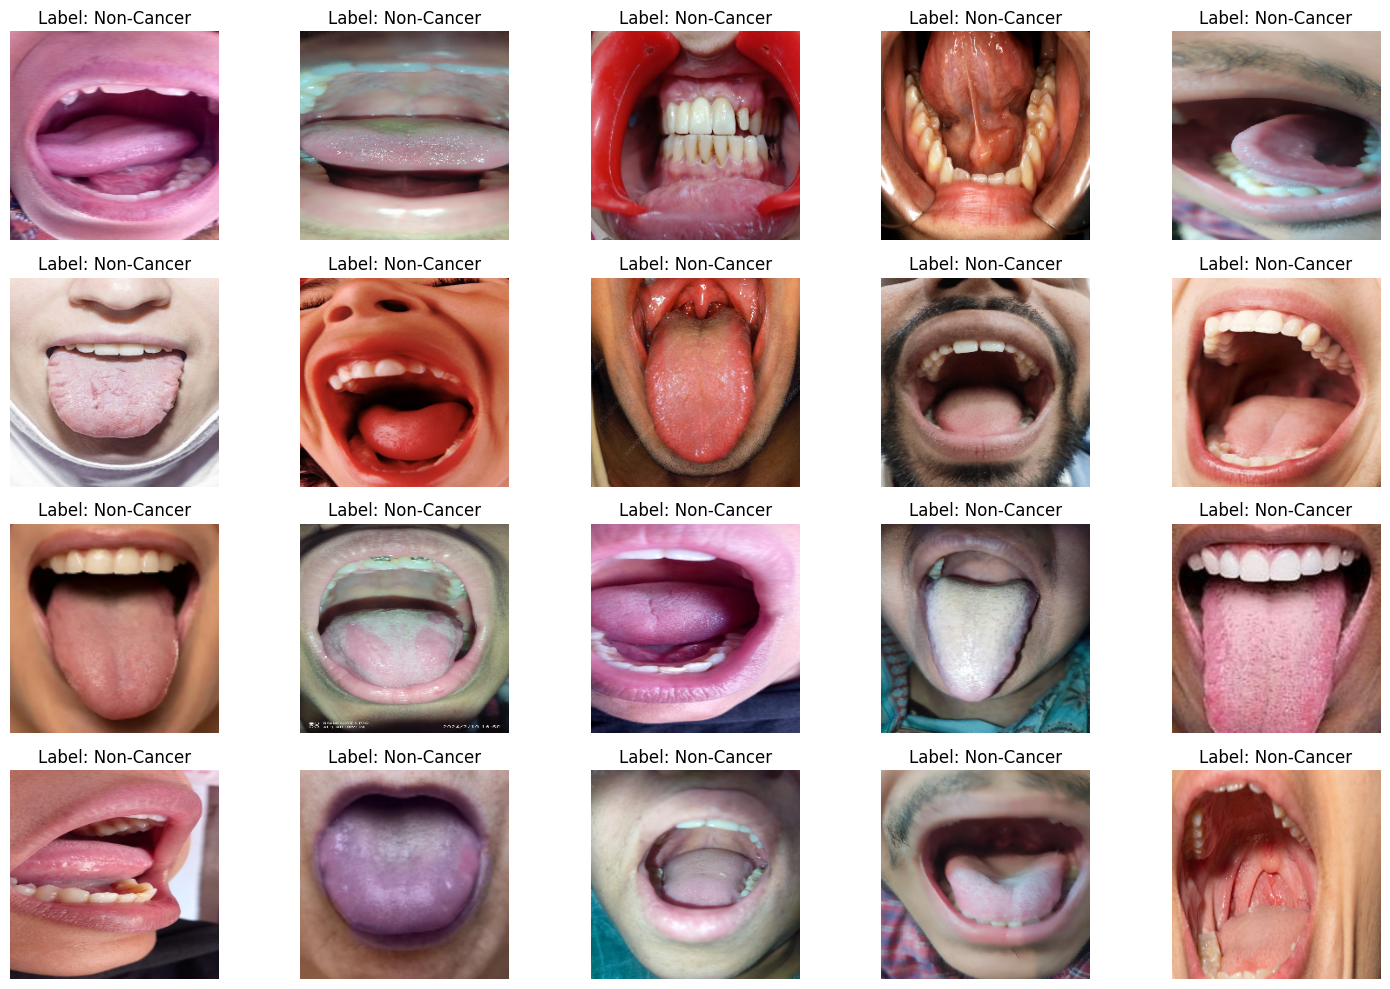

In [9]:
import matplotlib.pyplot as plt

# Plot 20 sample images
plt.figure(figsize=(15, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(dataset[i])
    plt.title("Label: {}".format("Non-Cancer" if labels[i] == 0 else "Cancer"))
    plt.axis('off')
plt.tight_layout()
plt.show()


In [10]:
import numpy as np

unique, counts = np.unique(labels, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Class Distribution:")
for label, count in class_distribution.items():
    class_name = "Non-Cancer" if label == 0 else "Cancer"
    print(f"{class_name}: {count} images")


Class Distribution:
Non-Cancer: 450 images
Cancer: 490 images


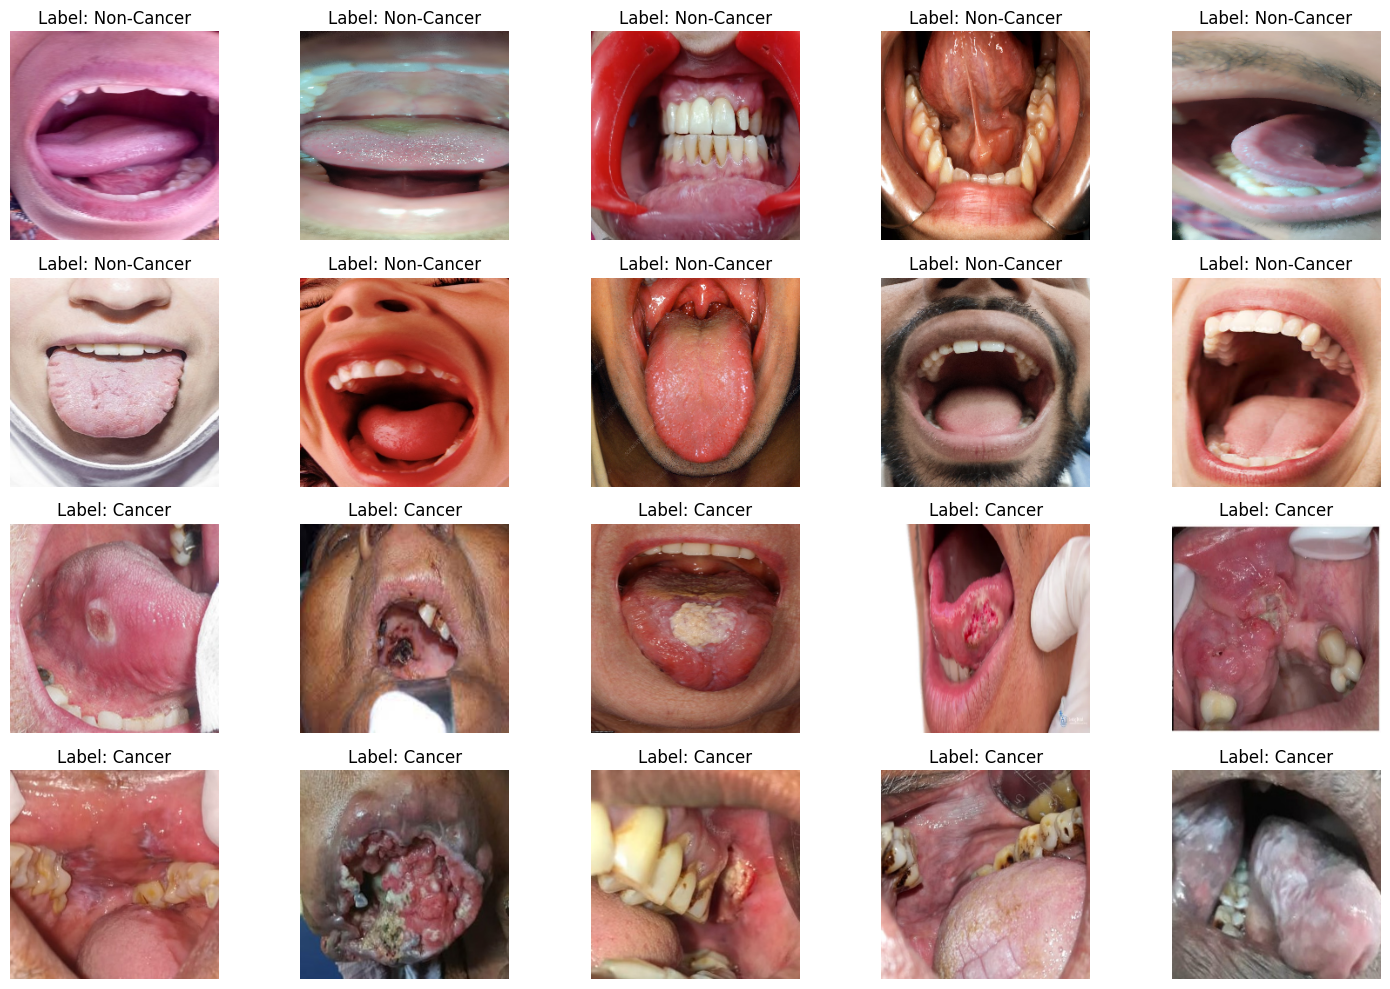

In [11]:
import matplotlib.pyplot as plt

# Find indices for each class
non_cancer_indices = np.where(labels == 0)[0][:10]
cancer_indices = np.where(labels == 1)[0][:10]

# Combine indices
selected_indices = np.concatenate([non_cancer_indices, cancer_indices])

# Plot 20 selected images
plt.figure(figsize=(15, 10))
for i, idx in enumerate(selected_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(dataset[idx])
    plt.title("Label: {}".format("Non-Cancer" if labels[idx] == 0 else "Cancer"))
    plt.axis('off')

plt.tight_layout()
plt.show()


In [12]:
# Convert to NumPy arrays and print shapes in a single line
print(np.array(dataset).shape, np.array(labels).shape)

(940, 240, 240, 3) (940,)


In [13]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import cv2

def load_and_process_dataset(path):
    """
    Load and process the oral cancer dataset from the specified path.

    Args:
        path (str): Base path to the dataset directory

    Returns:
        tuple: (dataset, labels, classes) where dataset is a numpy array of images,
               labels is a numpy array of corresponding labels, and classes is the list of class names
    """
    # Define corrected path
    corrected_path = os.path.join(path, 'OC')

    # Check if corrected path exists
    if not os.path.exists(corrected_path):
        raise ValueError(f"Directory {corrected_path} does not exist.")

    # Define class directories
    classes = ['non cancer', 'cancer']

    print(f"Expected classes: {classes}")

    # Initialize lists to store image data and labels
    images = []
    labels = []

    # Load images from each class directory
    for idx, cls in enumerate(classes):
        cls_dir = os.path.join(corrected_path, cls)
        if os.path.exists(cls_dir):
            print(f"Loading images from: {cls_dir}")
            class_images = 0
            for filename in os.listdir(cls_dir):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(cls_dir, filename)
                    # Read image using OpenCV
                    img = cv2.imread(img_path)
                    if img is not None:
                        # Convert BGR to RGB
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        # Resize image to a standard size (224x224)
                        img = cv2.resize(img, (224, 224))
                        images.append(img)
                        labels.append(idx)
                        class_images += 1
                    else:
                        print(f"Warning: Could not load image {img_path}")
            print(f"Loaded {class_images} images from class '{cls}'")
        else:
            print(f"Warning: Directory {cls_dir} does not exist.")

    if not images:
        raise ValueError("No valid images found in the specified directories.")

    # Convert lists to numpy arrays
    dataset = np.array(images)
    labels = np.array(labels)

    # Verify consistency
    if len(dataset) != len(labels):
        raise ValueError(f"Inconsistent number of samples: dataset has {len(dataset)} samples, labels has {len(labels)} samples.")

    print(f"Loaded {len(images)} images with {len(np.unique(labels))} unique labels.")

    return dataset, labels, classes

# ==================== MAIN ====================

if __name__ == "__main__":
    # Correct path to dataset
    path = '/root/.cache/kagglehub/datasets/zaidpy/new-oral-cancer/versions/1'

    # Load and process the dataset
    dataset, labels, classes = load_and_process_dataset(path)

    print("Dataset shape:", dataset.shape)
    print("Labels shape:", labels.shape)
    print("Classes:", classes)

    # First split: 80% train, 20% temp (val + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        dataset, labels, test_size=0.2, stratify=labels, random_state=42
    )
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_temp shape: {X_temp.shape}, y_temp shape: {y_temp.shape}")

    # Second split: 50% of temp for validation, 50% for test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    print("Training set shape:", X_train.shape)
    print("Validation set shape:", X_val.shape)
    print("Test set shape:", X_test.shape)


Expected classes: ['non cancer', 'cancer']
Loading images from: /root/.cache/kagglehub/datasets/zaidpy/new-oral-cancer/versions/1/OC/non cancer
Loaded 450 images from class 'non cancer'
Loading images from: /root/.cache/kagglehub/datasets/zaidpy/new-oral-cancer/versions/1/OC/cancer
Loaded 490 images from class 'cancer'
Loaded 940 images with 2 unique labels.
Dataset shape: (940, 224, 224, 3)
Labels shape: (940,)
Classes: ['non cancer', 'cancer']
X_train shape: (752, 224, 224, 3), y_train shape: (752,)
X_temp shape: (188, 224, 224, 3), y_temp shape: (188,)
Training set shape: (752, 224, 224, 3)
Validation set shape: (94, 224, 224, 3)
Test set shape: (94, 224, 224, 3)


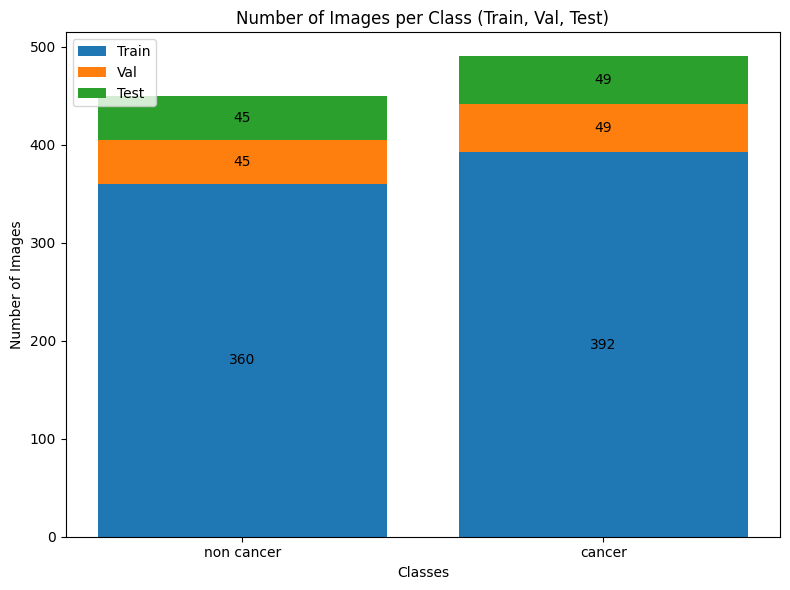

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load and process dataset
def load_and_process_dataset(path):
    corrected_path = os.path.join(path, 'OC')
    classes = ['non cancer', 'cancer']
    images, labels = [], []
    for idx, cls in enumerate(classes):
        cls_dir = os.path.join(corrected_path, cls)
        for fn in os.listdir(cls_dir):
            if fn.lower().endswith(('.jpg', '.jpeg', '.png')):
                labels.append(idx)
    return np.array(labels), classes

# Use the same path as before
path = '/root/.cache/kagglehub/datasets/zaidpy/new-oral-cancer/versions/1'
labels, classes = load_and_process_dataset(path)

# Split into train, val, test
X = np.arange(len(labels))  # dummy
y = labels
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Count per class
counts = {
    'train': [np.sum(y_train == i) for i in range(len(classes))],
    'val':   [np.sum(y_val   == i) for i in range(len(classes))],
    'test':  [np.sum(y_test  == i) for i in range(len(classes))]
}

# Plot stacked bar chart
x = np.arange(len(classes))
train_counts = counts['train']
val_counts   = counts['val']
test_counts  = counts['test']

plt.figure(figsize=(8,6))
p1 = plt.bar(x, train_counts)
p2 = plt.bar(x, val_counts, bottom=train_counts)
p3 = plt.bar(x, test_counts, bottom=[i+j for i,j in zip(train_counts, val_counts)])

plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class (Train, Val, Test)')
plt.xticks(x, classes)
plt.legend((p1[0], p2[0], p3[0]), ('Train', 'Val', 'Test'))

# Add labels
for bars in [p1, p2, p3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            y = bar.get_y() + height / 2
            plt.text(bar.get_x() + bar.get_width()/2, y, f'{int(height)}', ha='center', va='center')

plt.tight_layout()
plt.show()


[1/50] tr_loss:0.0414 tr_acc:77.79%  va_loss:0.0442 va_acc:65.96%
[2/50] tr_loss:0.0367 tr_acc:79.12%  va_loss:0.0565 va_acc:80.85%
[3/50] tr_loss:0.0247 tr_acc:85.64%  va_loss:0.0491 va_acc:82.98%
[4/50] tr_loss:0.0242 tr_acc:83.64%  va_loss:0.0239 va_acc:84.04%
[5/50] tr_loss:0.0208 tr_acc:87.77%  va_loss:0.0207 va_acc:84.04%
[6/50] tr_loss:0.0183 tr_acc:89.36%  va_loss:0.0216 va_acc:89.36%
[7/50] tr_loss:0.0191 tr_acc:88.56%  va_loss:0.0303 va_acc:90.43%
[8/50] tr_loss:0.0165 tr_acc:91.89%  va_loss:0.0213 va_acc:90.43%
[9/50] tr_loss:0.0128 tr_acc:92.42%  va_loss:0.0121 va_acc:93.62%
[10/50] tr_loss:0.0113 tr_acc:93.35%  va_loss:0.0113 va_acc:92.55%
[11/50] tr_loss:0.0092 tr_acc:94.55%  va_loss:0.0105 va_acc:93.62%
[12/50] tr_loss:0.0084 tr_acc:94.95%  va_loss:0.0096 va_acc:94.68%
[13/50] tr_loss:0.0079 tr_acc:95.21%  va_loss:0.0083 va_acc:95.74%
[14/50] tr_loss:0.0058 tr_acc:97.21%  va_loss:0.0096 va_acc:95.74%
[15/50] tr_loss:0.0067 tr_acc:96.01%  va_loss:0.0105 va_acc:94.68%
[16/

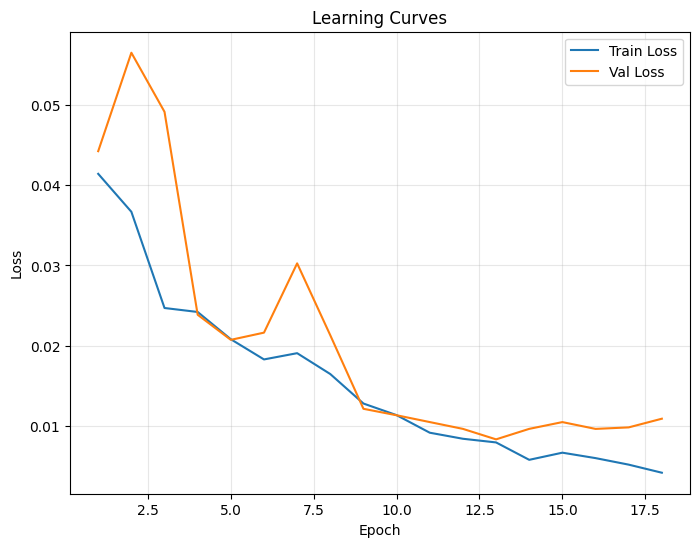

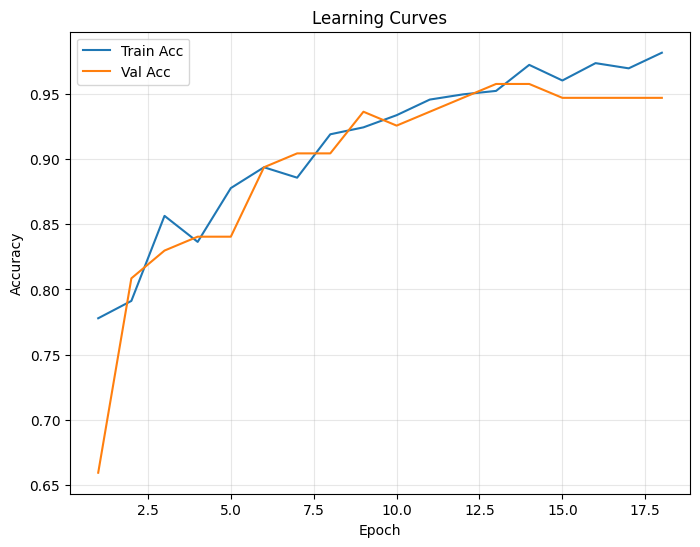


Test Loss: 0.0098 | Test Acc: 94.68%

=== Evaluation Summary ===
Accuracy:       0.9468
Precision:      0.9762
Recall:         0.9111
F1-Score:       0.9425
Cohen's Kappa:  0.8931
MCC:            0.8950
Log Loss:       0.2470

              precision    recall  f1-score   support

      cancer       0.92      0.98      0.95        49
  non cancer       0.98      0.91      0.94        45

    accuracy                           0.95        94
   macro avg       0.95      0.95      0.95        94
weighted avg       0.95      0.95      0.95        94



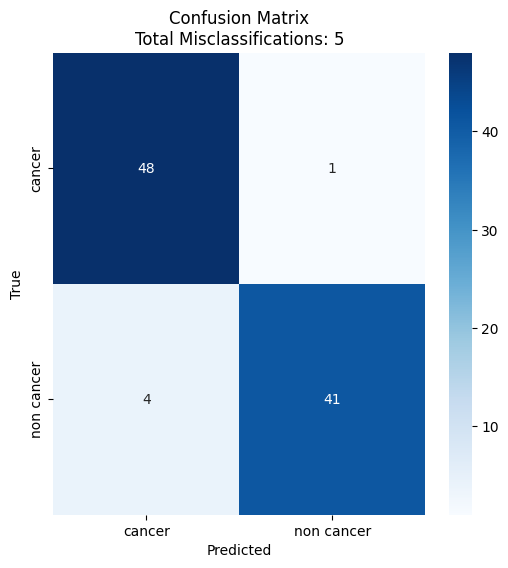

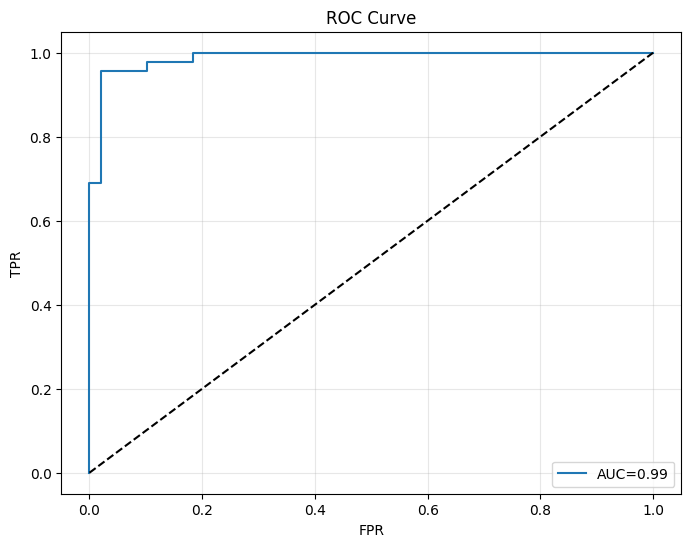

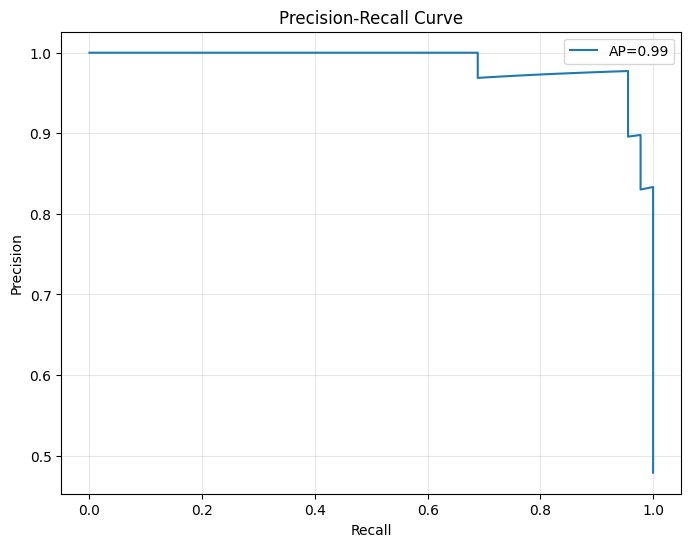

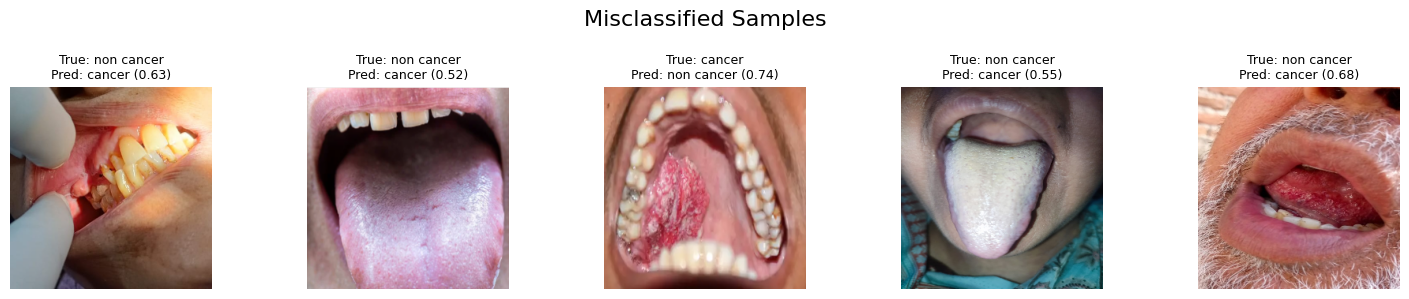

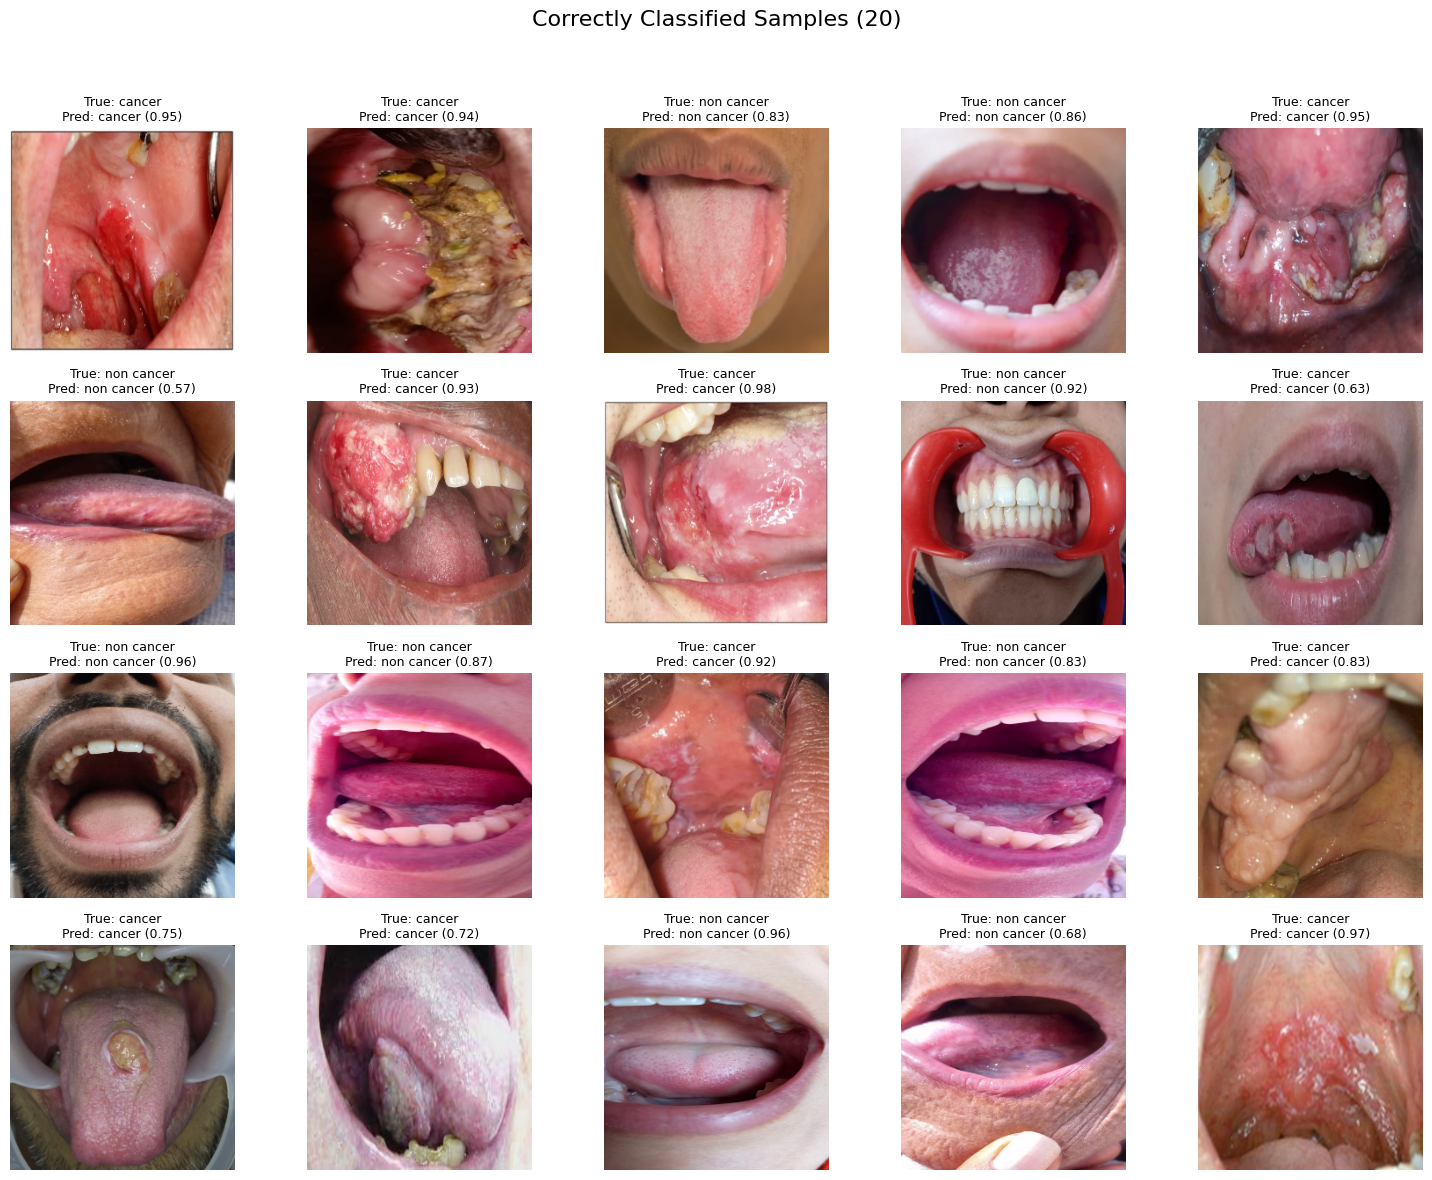

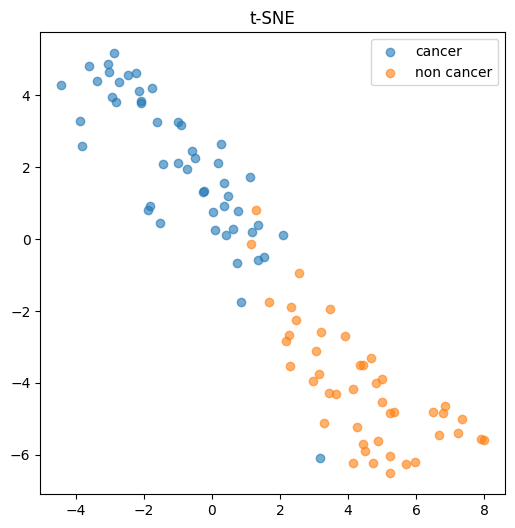

In [ ]:

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import GradScaler, autocast

from torchvision.models import densenet121, DenseNet121_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, precision_recall_curve,
    average_precision_score, classification_report,
    cohen_kappa_score, matthews_corrcoef, log_loss
)
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import seaborn as sns

# ─── CONFIG ─────────────────────────────────────────────────────────────────────
EPOCHS = 50
EARLY_STOPPING_PATIENCE = 5
BATCH_SIZE = 32
IMAGE_SIZE = 256
LEARNING_RATE = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CLASSES = ['cancer', 'non cancer']
N_CLASSES = len(CLASSES)

DATASET_PATH = '/root/.cache/kagglehub/datasets/zaidpy/new-oral-cancer/versions/1/OC'
if not os.path.isdir(DATASET_PATH):
    raise FileNotFoundError(f"Dataset path not found: {DATASET_PATH}")

# ─── DATASET ────────────────────────────────────────────────────────────────────
class OralCancerDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = np.array(Image.open(path).convert('RGB'))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, label

train_transforms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Rotate(15),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.CLAHE(clip_limit=2.0),
    A.ElasticTransform(alpha=1, sigma=50, p=0.5),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

# ─── MODEL ──────────────────────────────────────────────────────────────────────
class SelfAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.query = nn.Conv2d(channels, channels//8, 1)
        self.key   = nn.Conv2d(channels, channels//8, 1)
        self.value = nn.Conv2d(channels, channels,    1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B,C,H,W = x.shape
        q = self.query(x).view(B,-1,H*W).permute(0,2,1)
        k = self.key(x).view(B,-1,H*W)
        att = torch.softmax(q.bmm(k), dim=-1)
        v = self.value(x).view(B,-1,H*W)
        out = v.bmm(att.permute(0,2,1)).view(B,C,H,W)
        return self.gamma * out + x

class MultiDentNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = densenet121(weights=DenseNet121_Weights.DEFAULT)
        feats = base.features
        self.features = nn.Sequential(
            feats.conv0, feats.norm0, feats.relu0, feats.pool0,
            feats.denseblock1, feats.transition1, SelfAttention(128),
            feats.denseblock2, feats.transition2, SelfAttention(256),
            feats.denseblock3, feats.transition3, SelfAttention(512),
            feats.denseblock4, nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024,512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(0.7),
            nn.Linear(512,256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.6),
            nn.Linear(256,num_classes)
        )

    def forward(self, x):
        x = self.features(x).view(x.size(0), -1)
        return self.classifier(x)

# ─── UTILITIES ─────────────────────────────────────────────────────────────────
def denormalize(img_t: torch.Tensor):
    mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
    img = img_t * std + mean
    return img.clamp(0,1).permute(1,2,0).cpu().numpy()

def plot_images(indices, dataset, y_true, y_pred, y_prob, classes,
                filename, title_prefix, n_display=20):
    indices = list(indices)
    random.shuffle(indices)
    indices = indices[:n_display]
    cols = 5
    rows = (len(indices) + cols - 1)//cols
    plt.figure(figsize=(15, 3*rows))
    for i, idx in enumerate(indices):
        img_t, _ = dataset[idx]
        img = denormalize(img_t)
        t, p = y_true[idx], y_pred[idx]
        conf = y_prob[idx, p]
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {classes[t]}\nPred: {classes[p]} ({conf:.2f})", fontsize=9)
    plt.suptitle(title_prefix, fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.savefig(filename)
    plt.show()

def plot_curve(xs, ys, labels, xlabel, ylabel, title, filename, diag=False):
    plt.figure(figsize=(8,6))
    for y, lab in zip(ys, labels):
        plt.plot(xs, y, label=lab)
    if diag:
        plt.plot([0,1],[0,1],'k--')
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(); plt.grid(alpha=0.3)
    plt.savefig(filename); plt.show()

# ─── TRAIN/VALIDATE/EVALUATE ───────────────────────────────────────────────────
class FocalLoss(nn.Module):
    def __init__(self, α=0.25, γ=2.0):
        super().__init__(); self.α, self.γ = α, γ
    def forward(self, logits, targets):
        ce = nn.functional.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce)
        return (self.α * (1-pt)**self.γ * ce).mean()

def validate_epoch(model, loader, criterion):
    model.eval()
    loss_sum, correct = 0, 0
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for X,y in loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits = model(X)
            loss_sum += criterion(logits,y).item() * X.size(0)
            probs  = torch.softmax(logits,1)
            preds  = probs.argmax(1)
            correct+= (preds==y).sum().item()
            all_labels.extend(y.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
            all_probs.extend(probs.cpu().tolist())
    n = len(loader.dataset)
    return loss_sum/n, correct/n, np.array(all_labels), np.array(all_preds), np.array(all_probs)

def main():
    # Gather samples
    samples = []
    for idx, cls in enumerate(CLASSES):
        cls_dir = os.path.join(DATASET_PATH, cls)
        for fn in os.listdir(cls_dir):
            if fn.lower().endswith(('.jpg','jpeg','png')):
                samples.append((os.path.join(cls_dir, fn), idx))
    random.shuffle(samples)

    # Split
    paths, labels = zip(*samples)
    X_tr, X_tmp, y_tr, y_tmp = train_test_split(
        paths, labels, test_size=0.2, stratify=labels, random_state=42
    )
    X_va, X_te, y_va, y_te = train_test_split(
        X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
    )

    train_ds = MultiDentNet(list(zip(X_tr,y_tr)), transform=train_transforms)
    val_ds   = MultiDentNet(list(zip(X_va,y_va)), transform=val_transforms)
    test_ds  = MultiDentNet(list(zip(X_te,y_te)), transform=val_transforms)

    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # Build model etc.
    model     = MultiDentNet(N_CLASSES).to(DEVICE)
    criterion = FocalLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2)
    scaler    = GradScaler()

    best_loss, patience = float('inf'), 0
    history = {'tr_loss':[], 'tr_acc':[], 'va_loss':[], 'va_acc':[]}

    # Training
    for epoch in range(1, EPOCHS+1):
        model.train()
        run_loss, run_correct = 0, 0
        for X,y in train_dl:
            X,y = X.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            with autocast(device_type=DEVICE.type):
                logits = model(X)
                loss   = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            run_loss    += loss.item()*X.size(0)
            run_correct += (logits.argmax(1)==y).sum().item()

        tr_loss = run_loss/len(train_ds)
        tr_acc  = run_correct/len(train_ds)
        history['tr_loss'].append(tr_loss)
        history['tr_acc'].append(tr_acc)

        va_loss, va_acc, *_ = validate_epoch(model, val_dl, criterion)
        history['va_loss'].append(va_loss)
        history['va_acc'].append(va_acc)

        print(f"[{epoch}/{EPOCHS}] tr_loss:{tr_loss:.4f} tr_acc:{tr_acc:.2%}  va_loss:{va_loss:.4f} va_acc:{va_acc:.2%}")

        scheduler.step(va_loss)
        if va_loss < best_loss:
            best_loss, patience = va_loss, 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience += 1
            if patience >= EARLY_STOPPING_PATIENCE:
                print("Early stopping.")
                break

    # Learning curves
    epochs = list(range(1, len(history['tr_loss'])+1))
    plot_curve(epochs, [history['tr_loss'], history['va_loss']], ['Train Loss','Val Loss'],
               'Epoch','Loss','Learning Curves','learning_curves_loss.png')
    plot_curve(epochs, [history['tr_acc'], history['va_acc']], ['Train Acc','Val Acc'],
               'Epoch','Accuracy','Learning Curves','learning_curves_acc.png')

    # Test evaluation & metrics
    model.load_state_dict(torch.load('best_model.pth', map_location=DEVICE))
    test_loss, test_acc, test_true, test_preds, test_probs = validate_epoch(model, test_dl, criterion)
    print(f"\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.2%}\n")

    accuracy_val  = test_acc
    precision_val = precision_score(test_true, test_preds)
    recall_val    = recall_score(test_true, test_preds)
    f1_val        = f1_score(test_true, test_preds)
    kappa         = cohen_kappa_score(test_true, test_preds)
    mcc           = matthews_corrcoef(test_true, test_preds)
    logloss_val   = log_loss(test_true, test_probs)

    print("=== Evaluation Summary ===")
    print(f"Accuracy:       {accuracy_val:.4f}")
    print(f"Precision:      {precision_val:.4f}")
    print(f"Recall:         {recall_val:.4f}")
    print(f"F1-Score:       {f1_val:.4f}")
    print(f"Cohen's Kappa:  {kappa:.4f}")
    print(f"MCC:            {mcc:.4f}")
    print(f"Log Loss:       {logloss_val:.4f}\n")

    print(classification_report(test_true, test_preds, target_names=CLASSES))

    # Confusion matrix
    cm = confusion_matrix(test_true, test_preds)
    total_errors = np.sum(cm) - np.trace(cm)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'Confusion Matrix\nTotal Misclassifications: {total_errors}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png')
    plt.show()

    # ROC & PR
    fpr, tpr, _ = roc_curve(test_true, test_probs[:,1])
    plot_curve(fpr, [tpr], [f"AUC={roc_auc_score(test_true,test_probs[:,1]):.2f}"],
               'FPR','TPR','ROC Curve','roc_curve.png', diag=True)
    prec, rec, _ = precision_recall_curve(test_true, test_probs[:,1])
    plot_curve(rec, [prec], [f"AP={average_precision_score(test_true,test_probs[:,1]):.2f}"],
               'Recall','Precision','Precision-Recall Curve','pr_curve.png')

    # Misclassified and Correctly Classified images
    mis_idxs = np.where(test_true != test_preds)[0]
    cor_idxs = np.where(test_true == test_preds)[0]
    plot_images(mis_idxs, test_ds, test_true, test_preds, test_probs, CLASSES,
                'misclassified.png', 'Misclassified Samples')
    plot_images(cor_idxs, test_ds, test_true, test_preds, test_probs, CLASSES,
                'correctly_classified20.png', 'Correctly Classified Samples (20)', n_display=20)

    # t-SNE
    feats, labs = [], []
    for X,y in test_dl:
        with torch.no_grad():
            f = model.features(X.to(DEVICE)).view(X.size(0), -1).cpu().numpy()
        feats.append(f); labs.append(y.numpy())
    feats = np.vstack(feats); labs = np.concatenate(labs)
    perp = min(len(feats)-1, 30)
    emb = TSNE(n_components=2, perplexity=perp, random_state=42).fit_transform(feats)
    plt.figure(figsize=(6,6))
    for i,c in enumerate(CLASSES):
        idx = labs==i
        plt.scatter(emb[idx,0], emb[idx,1], label=c, alpha=0.6)
    plt.legend(); plt.title("t-SNE"); plt.savefig('tsne.png'); plt.show()

if __name__ == "__main__":
    main()
